In [705]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [706]:
# GLOBAL VARS
dataset_size = 2000
lr_faces = 1e-4
lr_scenes = 1e-4
lr_model = 1e-2
batch_size = 16

In [707]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models


In [708]:
# # try to read all the images to see if any are missing or corrupted
# df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))

# # Delete the columns: "user" and "index" and "datetime"
# if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
#     df = df.drop(columns=["user", "index", "datetime"])

# # remove leading slash from image_path
# if df["image_path"].iloc[0].startswith("/"):
#     df["image_path"] = df["image_path"].str.lstrip("/")

# # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
# df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
# # change the occurences of *, : ? in the image_path to _
# df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)

# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)
# # Remove corrupted entries from dataframe
# df = df.drop(index=corrupted_indices).reset_index(drop=True)
# # save the cleaned dataframe as pickle
# df.to_pickle("clean_findingemo.pkl")

df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))

In [709]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [710]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [711]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [712]:
len(df)

25867

In [713]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [714]:
df.tail()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
1995,Run_2/Optimistic adults nursing home/186960003...,Undefined,"Children,Youth",2,5,Joy,"BodyLanguage,FacialExpression",1
1996,Run_2/Raging teenagers spring/72359342.jpg,Undefined,Young Adults,2,6,Anticipation,"BodyLanguage,FacialExpression",2
1997,Run_1/Compassionate people protest/proud-boys-...,Undefined,Adults,2,3,Joy,"BodyLanguage,ConflictCtxtPerson,Context,Facial...",2
1998,Run_2/Grateful adults school/School-2.jpg,Undefined,"Children,Youth,Young Adults,Adults",2,4,Serenity,"BodyLanguage,FacialExpression",1
1999,Run_2/Sad seniors theater/nutan-prasad-homage-...,Undefined,Adults,-3,6,Grief,"BodyLanguage,FacialExpression",1


In [715]:
def valence_to_class(v):
    if v < 0:
        return "sad"
    if v == 0:
        return "neutral"
    else:
        return "happy"

In [716]:
# I'm going to simplify the emotions to happy, sad and neutral first
df['emo3'] = df['valence'].apply(valence_to_class)

In [717]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo3
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,neutral
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,neutral
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,happy
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,happy
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,neutral


In [718]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [719]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, "CategoriesPlaces365.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)
categories_365_df.head()

,commercial,summer,sport,playful,royal,relaxing,house_interior,food,cold,scary,transport,work,nature,horeca,agriculture,depressing,industrial,urban,cultural,woods
0,bakery_shop,harbor,arena_hockey,nursery,banquet_hall,jacuzzi_indoor,living_room,pantry,crevasse,attic,airfield,home_office,viaduct,bar,vegetable_garden,hospital,assembly_line,building_facade,church_outdoor,hunting_lodge_outdoor
1,butchers_shop,berth,arena_performance,playroom,ballroom,bedroom,kitchen,dining_room,mountain_snowy,basement,airplane_cabin,bank_vault,dam,pub_indoor,wheat_field,hospital_room,auto_factory,downtown,mosque_outdoor,cottage
2,clothing_store,coast,arena_rodeo,childs_room,bedchamber,bathroom,closet,fastfood_restaurant,ice_floe,alley,airport_terminal,server_room,badlands,cafeteria,wind_farm,jail_cell,engine_room,street,synagogue_outdoor,tree_house
3,department_store,grotto,baseball_field,candy_store,auto_showroom,television_room,dorm_room,restaurant,ice_shelf,catacomb,railroad_track,auditorium,canyon,coffee_shop,barn,army_base,industrial_area,shopfront,temple_asia,inn_outdoor
4,jewelry_shop,islet,basketball_court_indoor,florist_shop_indoor,church_indoor,shower,hotel_room,restaurant_kitchen,iceberg,NaN,train_interior,classroom,cliff,pub_indoor,farm,trench,oilrig,parking_lot,mausoleum,NaN


In [720]:
# get the counts of the labels of emo3
df['emo3'].value_counts()

emo3
happy      1229
sad         486
neutral     285
Name: count, dtype: int64

In [721]:
# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

mapped_categories = sorted(list(dict.fromkeys(category_mapping.values())))
print("Mapped Categories:", mapped_categories)

Mapped Categories: ['agriculture', 'cold', 'commercial', 'cultural', 'depressing', 'food', 'horeca', 'house_interior', 'industrial', 'nature', 'playful', 'relaxing', 'royal', 'scary', 'sport', 'summer', 'transport', 'urban', 'woods', 'work']


In [722]:
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)

# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)

print(len(category_mapping))

365


In [723]:
finding_emo_labels = sorted(df["emotion"].unique().tolist())
print(finding_emo_labels)

['Acceptance', 'Admiration', 'Amazement', 'Anger', 'Annoyance', 'Anticipation', 'Apprehension', 'Boredom', 'Disgust', 'Distraction', 'Ecstasy', 'Fear', 'Grief', 'Interest', 'Joy', 'Loathing', 'Pensiveness', 'Rage', 'Sadness', 'Serenity', 'Surprise', 'Terror', 'Trust', 'Vigilance']


In [724]:
# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0

In [725]:
def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    print(scene_categories[scene_idx_365], "->", mapped_categories[mapped_idx])

In [726]:
for i in range(len(scene_categories)):
    get_mapped_category(i)

airfield -> transport
airplane_cabin -> transport
airport_terminal -> transport
alcove -> house_interior
alley -> scary
amphitheater -> cultural
amusement_arcade -> playful
amusement_park -> playful
apartment_building_outdoor -> urban
aquarium -> cultural
aqueduct -> nature
arcade -> playful
arch -> cultural
archaelogical_excavation -> cultural
archive -> cultural
arena_hockey -> sport
arena_performance -> sport
arena_rodeo -> sport
army_base -> depressing
art_gallery -> cultural
art_school -> work
art_studio -> cultural
artists_loft -> house_interior
assembly_line -> industrial
athletic_field_outdoor -> sport
atrium_public -> work
attic -> scary
auditorium -> work
auto_factory -> industrial
auto_showroom -> royal
badlands -> nature
bakery_shop -> commercial
balcony_exterior -> urban
balcony_interior -> house_interior
ball_pit -> playful
ballroom -> royal
bamboo_forest -> nature
bank_vault -> work
banquet_hall -> royal
bar -> horeca
barn -> agriculture
barndoor -> house_interior
baseba

In [727]:
N = dataset_size
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 1600
Test indices length: 400


In [728]:
def show_image(index):
    img_path = os.path.join(findingemo_dir, df.loc[index, 'image_path'])
    print("Image path:", img_path)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Image path: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\Run_2/Shocked retiree playing/GettyImages-51740214.jpg


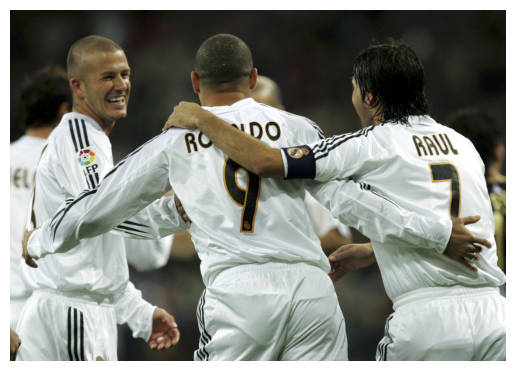

In [729]:
show_image(train_indices[0])


In [730]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [731]:
print(torch.cuda.is_available())
NUM_CLASSES = 7                  # FER2013 has 7 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [732]:
def train_resnet_fer2013(resnet_version=18,
                         batch_size=128,
                         lr=2e-4,
                         epochs=15,
                         save_name=None):
    print(f"Training ResNet-{resnet_version} on FER2013")
    print(f"Batch size: {batch_size}, LR: {lr}, Epochs: {epochs}")

    print("Using device:", DEVICE)

    # let cuDNN pick the fastest kernels for this image size
    torch.backends.cudnn.benchmark = True

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]),
    ])


    root = os.path.join(data_dir, "fer2013")      
    train_dataset = datasets.ImageFolder(root=f"{root}/train",
                                        transform=transform)
    val_dataset   = datasets.ImageFolder(root=f"{root}/test",
                                        transform=transform)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True, persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True, persistent_workers=True
    )

    print("Train samples:", len(train_dataset))
    print("Val samples:", len(val_dataset))

    if resnet_version == 18:
        resnet = models.resnet18(weights="IMAGENET1K_V1")
    elif resnet_version == 50:
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, NUM_CLASSES)
    resnet = resnet.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet.parameters(), lr=lr)

    scaler = GradScaler()

     # Determine save path
    if save_name is None:
        save_name = f"resnet{resnet_version}_fer2013.pth"
    save_path = os.path.join(model_dir, save_name)

    best_val_acc = 0.0

    for epoch in range(epochs):
        resnet.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda"):         
                outputs = resnet(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100. * correct / total
        print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f}%")

        # ---------------- Validation ----------------
        resnet.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)
                with autocast(device_type="cuda"):
                    outputs = resnet(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        print(f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(resnet.state_dict(), save_path)
            print(f"Best model saved to {save_path} | Val Acc: {val_acc:.2f}%")

    print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")
    return best_val_acc


In [733]:
train_resnet_fer2013(resnet_version=50, save_name="resnet50_fer2013_v2.pth")

Training ResNet-50 on FER2013
Batch size: 128, LR: 0.0002, Epochs: 15
Using device: cuda
Train samples: 28709
Val samples: 7178


Epoch 1/15:   0%|          | 0/225 [00:48<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 4.18 GiB is allocated by PyTorch, and 113.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [701]:
def evaluate_resnet_fer2013(resnet, show_confusion_matrix=True):
   
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Using device: {DEVICE}")
    
    
    # Load test dataset
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    
    root = os.path.join(data_dir, "fer2013")
    test_dataset = datasets.ImageFolder(root=f"{root}/test", transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=128, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    print(f"Test samples: {len(test_dataset)}")
    
    # Collect predictions
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            
            with autocast(device_type="cuda"):
                outputs = resnet(images)
                _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = 100.0 * (all_preds == all_labels).sum() / len(all_labels)
    
    # Per-class accuracy
    class_accuracies = {}
    for i, class_name in enumerate(fer_classes):
        mask = all_labels == i
        if mask.sum() > 0:
            class_acc = 100.0 * (all_preds[mask] == all_labels[mask]).sum() / mask.sum()
            class_accuracies[class_name] = class_acc
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"{'='*60}")
    print("\nPer-class Accuracies:")
    for class_name, class_acc in class_accuracies.items():
        print(f"  {class_name:10s}: {class_acc:.2f}%")
    
    # Classification report
    print(f"\n{'='*60}")
    print("Classification Report:")
    print(f"{'='*60}")
    print(classification_report(all_labels, all_preds, target_names=fer_classes, digits=4))
    
    # Plot confusion matrix
    if show_confusion_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=fer_classes, yticklabels=fer_classes)
        plt.title(f'Confusion Matrix - ResNet\nAccuracy: {accuracy:.2f}%')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Normalized confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=fer_classes, yticklabels=fer_classes)
        plt.title(f'Normalized Confusion Matrix - ResNet')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    return {
        'accuracy': accuracy,
        'class_accuracies': class_accuracies,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }

Using device: cuda
Test samples: 7178


Evaluating: 100%|██████████| 57/57 [01:27<00:00,  1.54s/it]



Overall Accuracy: 27.88%

Per-class Accuracies:
  angry     : 21.61%
  disgust   : 30.63%
  fear      : 25.10%
  happy     : 40.30%
  neutral   : 26.85%
  sad       : 24.22%
  surprise  : 18.65%

Classification Report:
              precision    recall  f1-score   support

       angry     0.2037    0.2161    0.2097       958
     disgust     0.4722    0.3063    0.3716       111
        fear     0.2469    0.2510    0.2489      1024
       happy     0.3890    0.4030    0.3959      1774
     neutral     0.2468    0.2685    0.2572      1233
         sad     0.2490    0.2422    0.2455      1247
    surprise     0.2359    0.1865    0.2083       831

    accuracy                         0.2788      7178
   macro avg     0.2919    0.2677    0.2767      7178
weighted avg     0.2788    0.2788    0.2780      7178



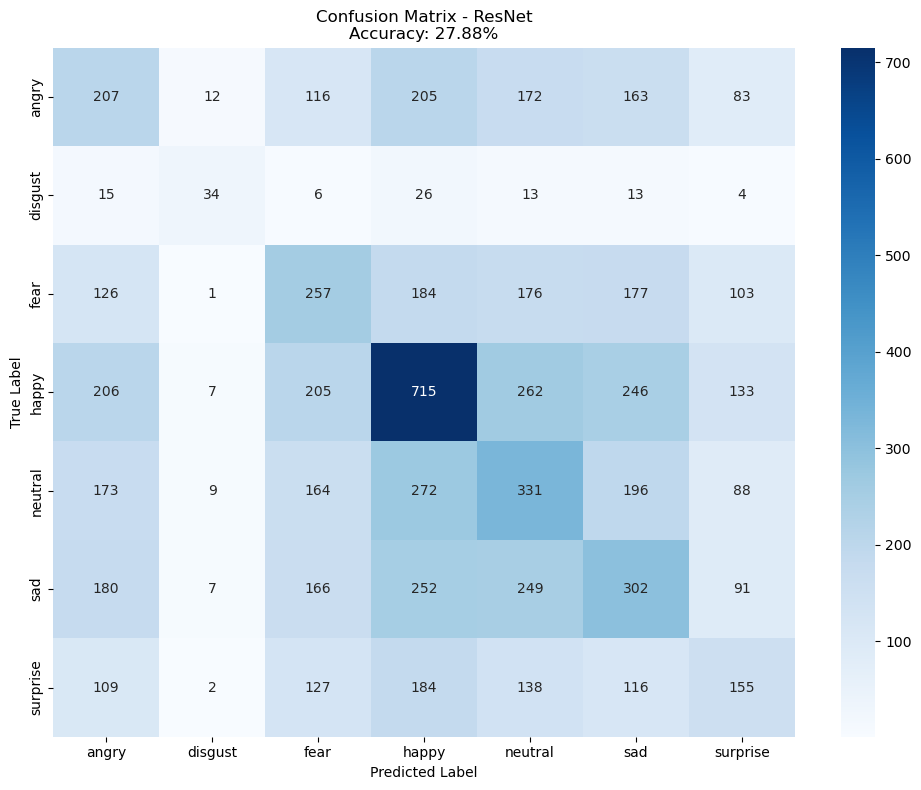

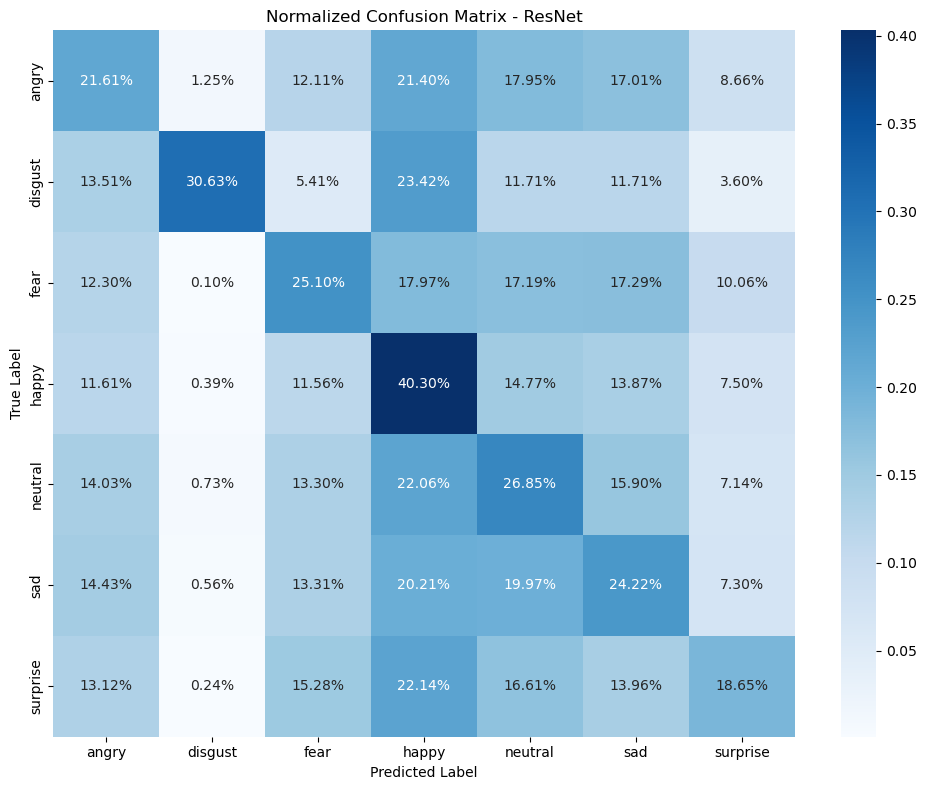

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [702]:
# Load the resnet model
resnet = models.resnet18(weights="IMAGENET1K_V1")
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, NUM_CLASSES)
resnet.load_state_dict(torch.load(os.path.join(model_dir, "resnet18_fer2013.pth"), map_location=DEVICE))
resnet = resnet.to(DEVICE)
# resnet.eval()

# Evaluate ResNet-18
results_18 = evaluate_resnet_fer2013(
    resnet=resnet,
    show_confusion_matrix=True
)

resnet.train()

In [703]:
# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
])


root = os.path.join(data_dir, "fer2013")      
train_dataset = datasets.ImageFolder(root=f"{root}/train",
                                    transform=transform)
val_dataset   = datasets.ImageFolder(root=f"{root}/test",
                                    transform=transform)

In [704]:
print(train_dataset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [650]:
# faces_dir = os.path.join(findingemo_dir, "faces")
# os.makedirs(faces_dir, exist_ok=True)

# csv_path = os.path.join(findingemo_dir, "face_boxes.csv")

# # Create and open CSV file for writing
# with open(csv_path, "w", newline="") as f:
#     writer = csv.writer(f)
#     # header row
#     writer.writerow(["index", "image_path", "face_rank", "x1", "y1", "x2", "y2", "score", "crop_path"])

#     # ========================================
#     # Iterate over the dataframe and process each image
#     # ========================================
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting faces"):
#         img_path = os.path.join(findingemo_dir, row["image_path"])

#         try:
#             detections = RetinaFace.detect_faces(img_path)
#         except Exception as e:
#             print(f"[Warning] Could not process {img_path}: {e}")
#             continue

#         # Skip images without faces
#         if not detections or isinstance(detections, str):
#             continue

#         # Collect all detected faces
#         faces = []
#         for det in detections.values():
#             x1, y1, x2, y2 = det["facial_area"]
#             area = (x2 - x1) * (y2 - y1)
#             faces.append({
#                 "coords": (x1, y1, x2, y2),
#                 "score": det["score"],
#                 "area": area
#             })

#         # Sort faces by area (largest first) and keep top 3
#         faces = sorted(faces, key=lambda x: x["area"], reverse=True)[:3]

#         # Crop and save top faces
#         img = Image.open(img_path).convert("RGB")
#         for i, face in enumerate(faces):
#             x1, y1, x2, y2 = face["coords"]
#             crop = img.crop((x1, y1, x2, y2)).resize((224, 224))
#             crop_name = f"img_{idx}_face_{i}.jpg"
#             crop_path = os.path.join(faces_dir, crop_name)
#             crop.save(crop_path, "JPEG", quality=90)

#             # Write bounding box info to CSV
#             writer.writerow([
#                 idx,                      # image index
#                 row["image_path"],        # relative image path
#                 i,                        # face rank (0=largest)
#                 x1, y1, x2, y2,           # bounding box coordinates
#                 face["score"],            # detection confidence
#                 crop_path                 # saved crop file
#             ])

# print(f"Finished! Cropped faces saved in: {faces_dir}")
# print(f"Bounding box CSV saved at: {csv_path}")


In [651]:
boxes_df = pd.read_csv(os.path.join(findingemo_dir, "face_boxes.csv"))

In [652]:
boxes_df.head()

,index,image_path,face_rank,x1,y1,x2,y2,score,crop_path
0,0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,236,226,284,292,0.998141,c:\Users\jarne\Documents\Code Masterthesis\nsa...
1,0,Run_2/Loving toddlers sports/haiti-kids.jpg,1,634,129,683,192,0.999440,c:\Users\jarne\Documents\Code Masterthesis\nsa...
2,0,Run_2/Loving toddlers sports/haiti-kids.jpg,2,133,246,181,307,0.999333,c:\Users\jarne\Documents\Code Masterthesis\nsa...
3,1,Run_2/Frustrated forty-something office/team-w...,0,113,277,180,411,0.941503,c:\Users\jarne\Documents\Code Masterthesis\nsa...
4,1,Run_2/Frustrated forty-something office/team-w...,1,242,80,300,165,0.999143,c:\Users\jarne\Documents\Code Masterthesis\nsa...


In [653]:
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(boxes_df['index'].value_counts()).fillna(0).astype(int)

In [654]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo3,nr_faces
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,neutral,3
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,neutral,3
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,happy,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,happy,3
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,neutral,3


In [655]:
# class FaceEmotionNet(nn.Module):
#     def __init__(self, pretrained_model):
#         super().__init__()
#         self.base = pretrained_model
#         self.use_checkpoint = True

#     def forward(self, x):
#         x = x.to(next(self.parameters()).device)
#         # Mask samples that are all zeros (dummy placeholders)
#         mask = (x.abs().sum(dim=[1,2,3]) == 0)

#         # Forward through pretrained base 
#         x = self.base(x)
#         x = F.softmax(x, dim=1)

#         # Replace outputs for dummy inputs with a uniform distribution
#         if mask.any():
#             uniform = torch.full_like(x, 1.0 / x.size(1))
#             x = torch.where(mask.unsqueeze(1), uniform, x)

#         return x
    
# face_model = FaceEmotionNet(pretrained_model=resnet).to(DEVICE)

# face_network = Network(face_model, "face_model", batching=True)
# face_network.optimizer = torch.optim.Adam(face_model.parameters(), lr=lr_faces)

In [656]:
class FaceEmotionNet(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.base = pretrained_model

    def forward(self, x):
        x = x.to(next(self.parameters()).device)
        # Mask samples that are all zeros (dummy placeholders)
        mask = (x.abs().sum(dim=[1,2,3]) == 0)

        # Forward through pretrained base
        x = self.base(x)
        x = F.softmax(x, dim=1)

        # Replace outputs for dummy inputs with a uniform distribution
        if mask.any():
            uniform = torch.full_like(x, 1.0 / x.size(1))
            x = torch.where(mask.unsqueeze(1), uniform, x)

        return x
    
face_model = FaceEmotionNet(pretrained_model=resnet).to(DEVICE)

face_network = Network(face_model, "face_model", batching=True)
face_network.optimizer = torch.optim.Adam(face_model.parameters(), lr=lr_faces)

In [657]:
for name, param in face_model.base.named_parameters():
    if name.startswith(("conv1", "bn1", "layer1", "layer2")):
        param.requires_grad = False

In [658]:
trainable = [name for name, p in face_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)


Trainable parameters: ['base.layer3.0.conv1.weight', 'base.layer3.0.bn1.weight', 'base.layer3.0.bn1.bias', 'base.layer3.0.conv2.weight', 'base.layer3.0.bn2.weight', 'base.layer3.0.bn2.bias', 'base.layer3.0.downsample.0.weight', 'base.layer3.0.downsample.1.weight', 'base.layer3.0.downsample.1.bias', 'base.layer3.1.conv1.weight', 'base.layer3.1.bn1.weight', 'base.layer3.1.bn1.bias', 'base.layer3.1.conv2.weight', 'base.layer3.1.bn2.weight', 'base.layer3.1.bn2.bias', 'base.layer4.0.conv1.weight', 'base.layer4.0.bn1.weight', 'base.layer4.0.bn1.bias', 'base.layer4.0.conv2.weight', 'base.layer4.0.bn2.weight', 'base.layer4.0.bn2.bias', 'base.layer4.0.downsample.0.weight', 'base.layer4.0.downsample.1.weight', 'base.layer4.0.downsample.1.bias', 'base.layer4.1.conv1.weight', 'base.layer4.1.bn1.weight', 'base.layer4.1.bn1.bias', 'base.layer4.1.conv2.weight', 'base.layer4.1.bn2.weight', 'base.layer4.1.bn2.bias', 'base.fc.weight', 'base.fc.bias']


In [659]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)

print("Loaded pretrained models")

Loaded pretrained models


In [660]:
class SceneNet(nn.Module):
    def __init__(self, pretrained_model, map_365 = map_365):
        super().__init__()
        self.base = pretrained_model
        self.register_buffer("map_365", map_365.clone().float())

    def forward(self, x):
        x = x.to(next(self.parameters()).device)
         # Forward through pretrained base
        logits = self.base(x)
        probs = torch.softmax(logits, dim=1)
        mapped_probs = torch.matmul(probs, self.map_365)
        return mapped_probs

scene_model = SceneNet(pretrained_model=scene_model_base).to(DEVICE)    
scene_network = Network(scene_model, "scene_model", batching=True)
scene_network.optimizer = torch.optim.Adam(scene_model.parameters(), lr=lr_scenes)    

In [661]:
for name, param in scene_model.base.named_parameters():
    if name.startswith(("conv1", "bn1", "layer1", "layer2")):
        param.requires_grad = False

In [662]:
trainable = [name for name, p in scene_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)


Trainable parameters: ['base.layer3.0.conv1.weight', 'base.layer3.0.bn1.weight', 'base.layer3.0.bn1.bias', 'base.layer3.0.conv2.weight', 'base.layer3.0.bn2.weight', 'base.layer3.0.bn2.bias', 'base.layer3.0.downsample.0.weight', 'base.layer3.0.downsample.1.weight', 'base.layer3.0.downsample.1.bias', 'base.layer3.1.conv1.weight', 'base.layer3.1.bn1.weight', 'base.layer3.1.bn1.bias', 'base.layer3.1.conv2.weight', 'base.layer3.1.bn2.weight', 'base.layer3.1.bn2.bias', 'base.layer4.0.conv1.weight', 'base.layer4.0.bn1.weight', 'base.layer4.0.bn1.bias', 'base.layer4.0.conv2.weight', 'base.layer4.0.bn2.weight', 'base.layer4.0.bn2.bias', 'base.layer4.0.downsample.0.weight', 'base.layer4.0.downsample.1.weight', 'base.layer4.0.downsample.1.bias', 'base.layer4.1.conv1.weight', 'base.layer4.1.bn1.weight', 'base.layer4.1.bn1.bias', 'base.layer4.1.conv2.weight', 'base.layer4.1.bn2.weight', 'base.layer4.1.bn2.bias', 'base.fc.weight', 'base.fc.bias']


In [663]:
from deepproblog.engines import ApproximateEngine

heuristic = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model4_1.pl"), [face_network, scene_network])
model.set_engine(ApproximateEngine(model, 10, heuristic, timeout=30, ignore_timeout=True, exploration=True))
model.optimizer = SGD(model, lr_model)

In [664]:
emotion_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]),
    ])

class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)

        index, face_rank = i
        nr_faces = int(df.loc[index, 'nr_faces'])

        if face_rank >= nr_faces:
            # return a dummy tensor of zeros
            return torch.zeros((3, 224, 224))
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
train_faces_dataset = FacesDataset(train_indices)
test_faces_dataset = FacesDataset(test_indices)
model.add_tensor_source("faces_train", train_faces_dataset)
model.add_tensor_source("faces_test", test_faces_dataset)

In [665]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img


In [666]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

train_scenes_dataset = SceneDataset(train_indices)
test_scenes_dataset = SceneDataset(test_indices)
model.add_tensor_source("scenes_train", train_scenes_dataset)
model.add_tensor_source("scenes_test", test_scenes_dataset)

In [667]:
class FindingEmoDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        super(FindingEmoDataset, self).__init__()
        self.indices = indices
        self.dataset_name = dataset_name
    
    def __getitem__(self, i):
        pass
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        index = self.indices[i]
        row = df.loc[index]
        sub_images = [Term("face_{}".format(x)) for x in range(3)]
        images = [
            Term("tensor", Term(f"faces_{self.dataset_name}", Constant(index), Constant(x))) for x in range(3)
        ]
        sub = {sub_images[x]: images[x] for x in range(3)}
        return Query(
            Term("final_emotion",
                 list2term(sub_images),
                 Term("tensor", Term(f"scenes_{self.dataset_name}", Constant(index))),
                 Constant(row['emo3'])
            ),
            substitution=sub,
        )
    
train_dataset = FindingEmoDataset(train_indices, "train")
test_dataset = FindingEmoDataset(test_indices, "test")

In [668]:
def display_tensor_as_image(x):
    tensor = x.squeeze(0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    array = tensor.permute(1, 2, 0).numpy()
    plt.imshow(array)
    plt.axis('off')
    plt.show()


In [669]:
train_dataset.to_query(np.random.randint(len(train_dataset)))

(1.0::final_emotion([face_0, face_1, face_2],tensor(scenes_train(469)),happy), {face_0: tensor(faces_train(469,0)), face_1: tensor(faces_train(469,1)), face_2: tensor(faces_train(469,2))})

In [670]:
train_scenes_dataset[(0,)]

tensor([[[ 0.4166, -0.1486, -0.0116,  ..., -0.2513, -0.1828,  0.0741],
         [ 0.5364, -0.2342, -0.2856,  ..., -0.1143,  0.3823,  0.6906],
         [-0.0458, -0.2856, -0.2513,  ...,  0.1768,  0.4508,  0.6734],
         ...,
         [ 0.5536,  0.2282, -0.0287,  ...,  1.0502,  1.1529,  1.1529],
         [-0.3027, -0.3541, -0.3541,  ...,  1.1872,  1.2557,  1.2557],
         [-0.3198, -0.3027, -0.3027,  ...,  1.2214,  1.2214,  1.2728]],

        [[ 0.6254,  0.1176,  0.2577,  ...,  0.0651,  0.1527,  0.3978],
         [ 0.7129,  0.0126, -0.0574,  ...,  0.1702,  0.6429,  1.0105],
         [ 0.1527,  0.0476,  0.0476,  ...,  0.4153,  0.7129,  0.9755],
         ...,
         [ 0.6604,  0.2752, -0.1800,  ...,  1.4657,  1.5357,  1.5182],
         [-0.5476, -0.6527, -0.7402,  ...,  1.6057,  1.6408,  1.6408],
         [-0.7752, -0.7927, -0.7752,  ...,  1.6232,  1.6232,  1.6583]],

        [[-0.5495, -0.8284, -0.7238,  ..., -1.3513, -1.2990, -1.0027],
         [-0.5147, -1.0376, -1.0201,  ..., -1

In [671]:
loader = DPLDataLoader(train_dataset, batch_size=batch_size)

In [672]:
train_obj = train_model(
    model,
    loader,
    3,
    log_iter=20
)

Training  for 3 epoch(s)
Epoch 1
Iteration:  20 	s:16.8736 	Average Loss:  0.0
0.8948297447307754	0.2699439829161757	0.03908424833446378
Iteration:  40 	s:18.2711 	Average Loss:  0.0
0.8948297447307754	0.2699439829161757	0.03908424833446378
Iteration:  60 	s:17.9759 	Average Loss:  0.0
0.8948297447307754	0.2699439829161757	0.03908424833446378
Iteration:  80 	s:17.8241 	Average Loss:  0.0
0.8948297447307754	0.2699439829161757	0.03908424833446378


Exception ignored on calling ctypes callback function: <function _foreignWrapper.<locals>.wrapper at 0x000001B31A02B2E0>
Traceback (most recent call last):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\pyswip\easy.py", line 528, in wrapper
    r = fun(*args)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\engines\approximate_engine.py", line 154, in func
    probabilities = net([term2list(inputs, False)])
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 126, in __call__
    for inputs in zip(*inputs):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 124, in <genexpr>
    inputs = (self.function(*e) for e in to_evaluate)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 11, in tensor_function
    return tuple(network.model.get_tensor(arg) for arg in args)
  File "c:\Users\jarne\miniconda3\envs\dpl_ba

PrologError: Caused by: 'call_with_time_limit(30,prove(final_emotion([tensor(faces_train(136,0)), tensor(faces_train(136,1)), tensor(faces_train(136,2))],tensor(scenes_train(136)),"happy"),10,Proofs,geometric_mean,true))'. Returned: 'error(domain_error(foreign_return_value, 12), context(/(face_model_extern, 2), _86))'.